In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import import_ipynb
from fin_module import ft    # fin_module 파일의 ft 클래스를 호출

In [20]:
# 변수 설정하기
t1 = 'AAPL'
t2 = 'AMD'
t3 = 'WMT'

stt = '2007-01-01'
end = '2022-09-09'

### ft 클래스를 Call 하기   ###
call_1 = ft(t1, stt, end)
call_2 = ft(t2, stt, end)
call_3 = ft(t3, stt, end)

In [21]:
### 메소드 사용해서 데이터 불러오기  ###
pot_1 = call_1.getCloseData()
pot_2 = call_2.getCloseData()
pot_3 = call_3.getCloseData()

In [22]:
# 데이터 합치기
closeDataSet = pd.concat([pot_1, pot_2, pot_3], axis=1)
closeDataSet.columns = [t1, t2, t3]
closeDataSet.dropna(inplace=True)
closeDataSet

,AAPL,AMD,WMT
Date,,,
2007-01-03,2.99,19.52,47.55
2007-01-04,3.06,19.79,47.78
2007-01-05,3.04,19.71,47.39
2007-01-08,3.05,19.47,47.00
2007-01-09,3.31,19.65,47.39
...,...,...,...
2022-09-02,155.81,80.24,133.00
2022-09-06,154.53,78.72,132.34
2022-09-07,155.96,79.61,135.74


In [23]:
# 리밸런싱 날짜
rebalancingDate = ft.getRebalancingDate(closeDataSet)

# 리밸런싱 비율, 동일비중으로 가정
portfolioWeight = [1 / len(closeDataSet.columns)] * len(closeDataSet.columns)
weightDf = pd.DataFrame([portfolioWeight] * len(rebalancingDate), index=rebalancingDate, columns=closeDataSet.columns)
weightDf

,AAPL,AMD,WMT
Date,,,
2007-01-31,0.333333,0.333333,0.333333
2007-02-28,0.333333,0.333333,0.333333
2007-03-30,0.333333,0.333333,0.333333
2007-04-30,0.333333,0.333333,0.333333
2007-05-31,0.333333,0.333333,0.333333
...,...,...,...
2022-05-31,0.333333,0.333333,0.333333
2022-06-30,0.333333,0.333333,0.333333
2022-07-29,0.333333,0.333333,0.333333


In [24]:
closeDataSet.loc[rebalancingDate]

,AAPL,AMD,WMT
Date,,,
2007-01-31,3.06,15.55,47.69
2007-02-28,3.02,15.07,48.31
2007-03-30,3.32,13.06,46.95
2007-04-30,3.56,13.82,47.92
2007-05-31,4.33,14.27,47.60
...,...,...,...
2022-05-31,148.84,101.86,128.63
2022-06-30,136.72,76.47,121.58
2022-07-29,162.51,94.47,132.05


In [25]:
# 1만 달러를 동일한 금액으로 매수했을 때 주식수

((10000 * weightDf) // closeDataSet.loc[rebalancingDate])

,AAPL,AMD,WMT
Date,,,
2007-01-31,1089.0,214.0,69.0
2007-02-28,1103.0,221.0,68.0
2007-03-30,1004.0,255.0,70.0
2007-04-30,936.0,241.0,69.0
2007-05-31,769.0,233.0,70.0
...,...,...,...
2022-05-31,22.0,32.0,25.0
2022-06-30,24.0,43.0,27.0
2022-07-29,20.0,35.0,25.0


In [26]:
totalAsset = 10000
prevQuantity = 0

portfolio = pd.DataFrame()
start = rebalancingDate[0]

for end in rebalancingDate[1:]:
    weight = weightDf.loc[start]              
    
    capacity = totalAsset * weight          # 자산별 금액
    
    priceData = closeDataSet.loc[start:end]
    priceOnRebalDay = priceData.iloc[0]     # 리밸런싱 당일 가격
    
    quantity = capacity // priceOnRebalDay    #  이번달 capa 에 따라 실제 보유해야 할 주식수 
#     print(quantity)
#     break 
    
    diffQuantity = quantity - prevQuantity    # 실제 매매해야 하는 수량, 양수 -> 매수, 음수 -> 매도
    fee = abs(diffQuantity) * priceOnRebalDay * 0.0015     # 수수료 0.15%

    leftCash = (capacity - quantity * priceOnRebalDay - fee).sum()   # 잔여 현금
    
    assetFlow = quantity * priceData               # 수량 * 가격 = 각 자산 흐름
    valueOnLastDay = assetFlow.iloc[-1].sum()      # 월말 평가액
    
#     print(assetFlow, valueOnLastDay)
#     break     

    assetFlow['leftCash'] = round(leftCash, 2)
#     print(assetFlow, valueOnLastDay)
#     break         
    
    portfolio = pd.concat([portfolio, assetFlow])      # 데이터프레임에 추가
    
    # 슬리피지를 고려하고 싶다면 여기에 적당한 패널티를 부여할 것
    totalAsset = (valueOnLastDay + leftCash)            # (월말 평가액 + 잔여 현금 - 수수료) totalAsset 업데이트
    prevQuantity = quantity
    start = end

portfolio

,AAPL,AMD,WMT,leftCash
Date,,,,
2007-01-31,3332.34,3327.70,3290.61,34.42
2007-02-01,3299.67,3374.78,3296.82,34.42
2007-02-02,3299.67,3357.66,3317.52,34.42
2007-02-05,3267.00,3338.40,3347.88,34.42
2007-02-06,3277.89,3278.48,3352.02,34.42
...,...,...,...,...
2022-09-02,58428.75,55766.80,59185.00,57.29
2022-09-06,57948.75,54710.40,58891.30,57.29
2022-09-07,58485.00,55328.95,60404.30,57.29


In [27]:
# 매달 마지막 영업일엔 리밸런싱이 들어간 row만 남긴다.
portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')]
portfolio

,AAPL,AMD,WMT,leftCash
Date,,,,
2007-01-31,3332.34,3327.70,3290.61,34.42
2007-02-01,3299.67,3374.78,3296.82,34.42
2007-02-02,3299.67,3357.66,3317.52,34.42
2007-02-05,3267.00,3338.40,3347.88,34.42
2007-02-06,3277.89,3278.48,3352.02,34.42
...,...,...,...,...
2022-09-02,58428.75,55766.80,59185.00,57.29
2022-09-06,57948.75,54710.40,58891.30,57.29
2022-09-07,58485.00,55328.95,60404.30,57.29


In [28]:
portfolio.index.astype(str).str[0:7]

Index(['2007-01', '2007-02', '2007-02', '2007-02', '2007-02', '2007-02',
       '2007-02', '2007-02', '2007-02', '2007-02',
       ...
       '2022-08', '2022-08', '2022-08', '2022-08', '2022-09', '2022-09',
       '2022-09', '2022-09', '2022-09', '2022-09'],
      dtype='object', name='Date', length=3931)

In [29]:
portfolio = portfolio[~portfolio.index.astype(str).str[0:7].duplicated(keep='last')]
portfolio

,AAPL,AMD,WMT,leftCash
Date,,,,
2007-01-31,3332.34,3327.70,3290.61,34.42
2007-02-28,3291.80,3285.26,3285.08,19.27
2007-03-30,3223.72,3225.82,3192.60,34.45
2007-04-30,3385.56,3385.90,3354.40,37.15
2007-05-31,3658.85,3653.12,3617.60,52.21
...,...,...,...,...
2022-05-31,60429.04,60504.84,60456.10,122.23
2022-06-30,52637.20,52687.83,52644.14,205.20
2022-07-29,61591.29,61594.44,61667.35,172.51


In [30]:
portfolio.iloc[-1] / portfolio.iloc[0]

AAPL        17.709402
AMD         17.846486
WMT         18.505323
leftCash     1.664439
dtype: float64

In [31]:
# 포트폴리오 자산흐름
portfolioAssetFlow = portfolio.sum(axis=1)
portfolioAssetFlow

Date
2007-01-31      9985.07
2007-02-28      9881.41
2007-03-30      9676.59
2007-04-30     10163.01
2007-05-31     10981.78
                ...    
2022-05-31    181512.21
2022-06-30    158174.37
2022-07-29    185025.59
2022-08-31    176984.19
2022-09-09    179352.59
Length: 189, dtype: float64

In [32]:
# 누적 수익률
cumReturn = portfolioAssetFlow / portfolioAssetFlow.iloc[0]
cumReturn

Date
2007-01-31     1.000000
2007-02-28     0.989619
2007-03-30     0.969106
2007-04-30     1.017821
2007-05-31     1.099820
                ...    
2022-05-31    18.178361
2022-06-30    15.841088
2022-07-29    18.530225
2022-08-31    17.724882
2022-09-09    17.962076
Length: 189, dtype: float64

cagr : 47.04087
mdd: 50.443519292193386


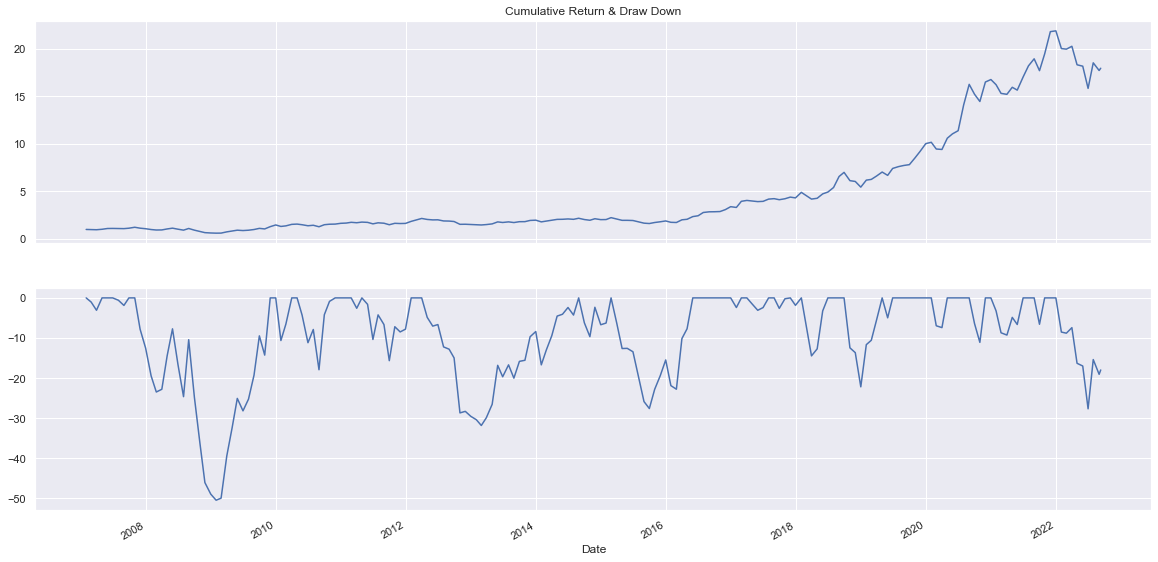

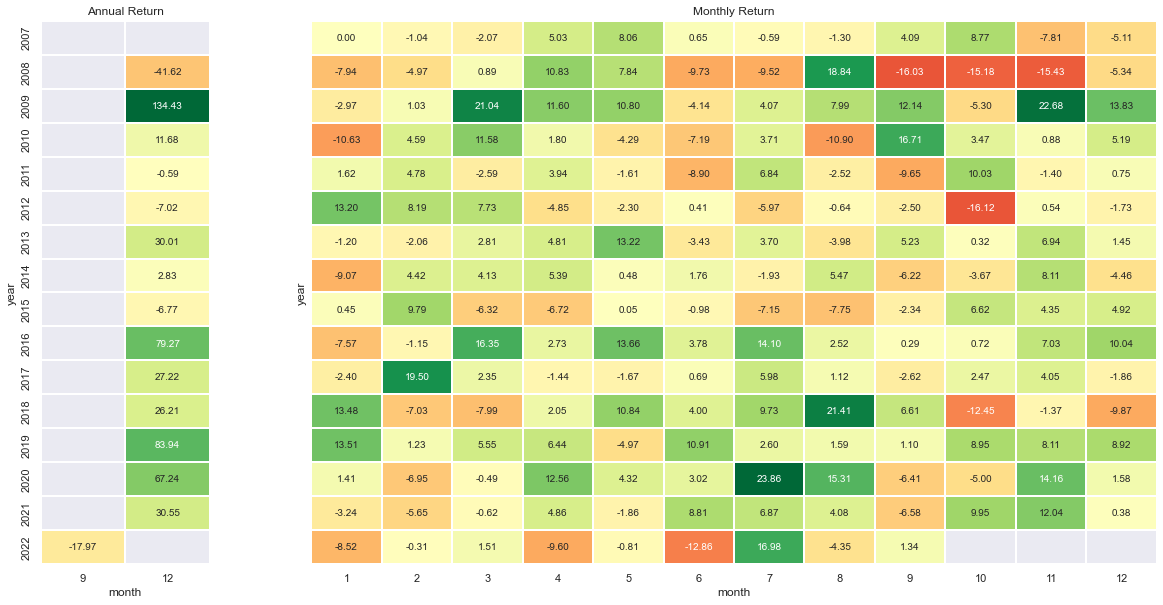

In [33]:
_,_,_ = ft.getEvaluation(cumReturn)

cagr : 1.20498
mdd: 53.53094463714015


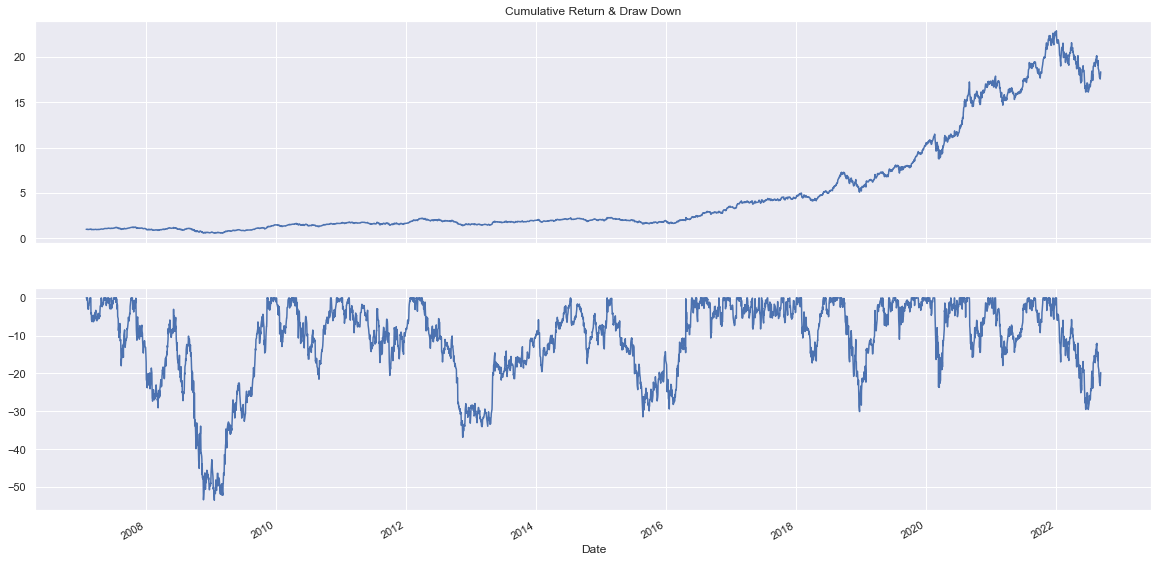

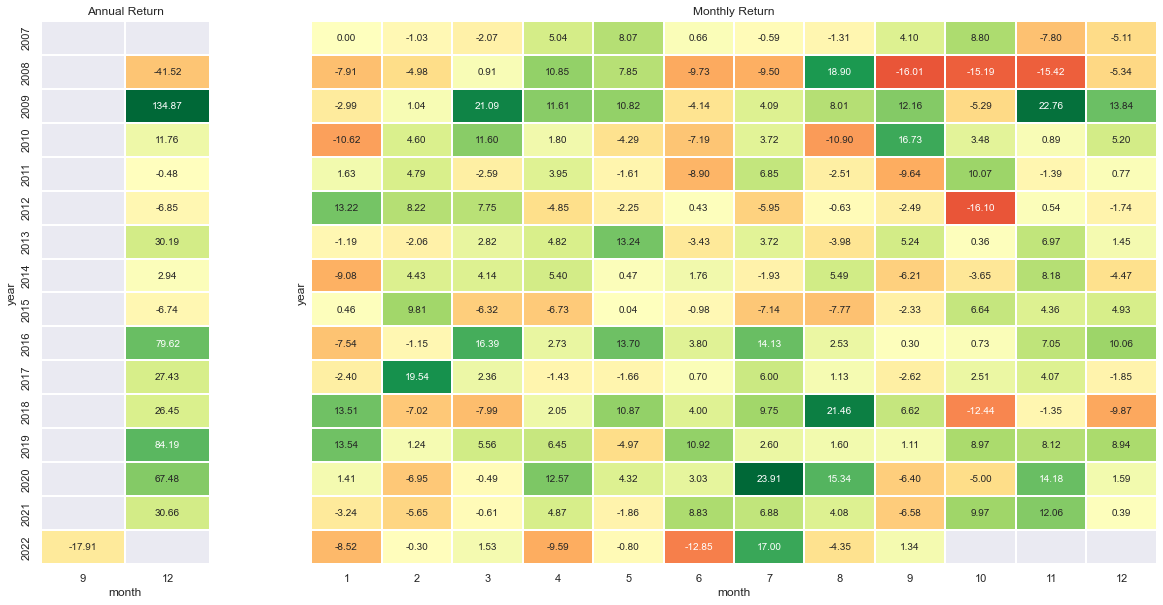

In [34]:
# 수수료 고려하지 않았을 때
_, cumReturnWithoutFee = ft.getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weightDf)
_,_,_ = ft.getEvaluation(cumReturnWithoutFee)